In [4]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import time

In [5]:
sdir='C:/Users/Hi/PycharmProjects/FYP2/Plant_leave_diseases_dataset_without_augmentation'
min_samples=40 # set limit for minimum images a class must have to be included in the dataframe
filepaths = []
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir, klass)
    flist=os.listdir(classpath)
    if len(flist) >= min_samples:
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    else:
        print('class ', klass, ' has only', len(flist), ' samples and will not be included in dataframe')
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  48874   test_df length:  2716   valid_df length:  2715
The number of classes in the dataset is:  38
            CLASS               IMAGE COUNT 
      Apple___Apple_scab            567     
      Apple___Black_rot             559     
   Apple___Cedar_apple_rust         248     
       Apple___healthy             1480     
     Blueberry___healthy           1352     
   Cherry___Powdery_mildew          947     
       Cherry___healthy             769     
Corn___Cercospora_leaf_spot Gray_leaf_spot      462     
      Corn___Common_rust           1073     
 Corn___Northern_Leaf_Blight        886     
        Corn___healthy             1046     
      Grape___Black_rot            1062     
 Grape___Esca_(Black_Measles)      1245     
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)      968     
       Grape___healthy              381     
Orange___Haunglongbing_(Citrus_greening)     4956     
    Peach___Bacterial_spot         2067     
       Peach___healthy              32

In [6]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=200 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=36
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  200  and the minimum samples in any class is  36


In [7]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=200 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(200,200) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  7537
Found 137 validated image filenames.     for class        Potato___healthy        creating  63   augmented images 
Total Augmented images created=  63
Length of augmented dataframe is now  7600


EfficientNetB3 Model

In [8]:
batch_size=20 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 7600 validated image filenames belonging to 38 classes.          for train generator 
Found 2715 validated image filenames belonging to 38 classes.          for valid generator 
Found 2716 validated image filenames belonging to 38 classes.          for test generator 
test batch size:  28   test steps:  97  number of classes :  38


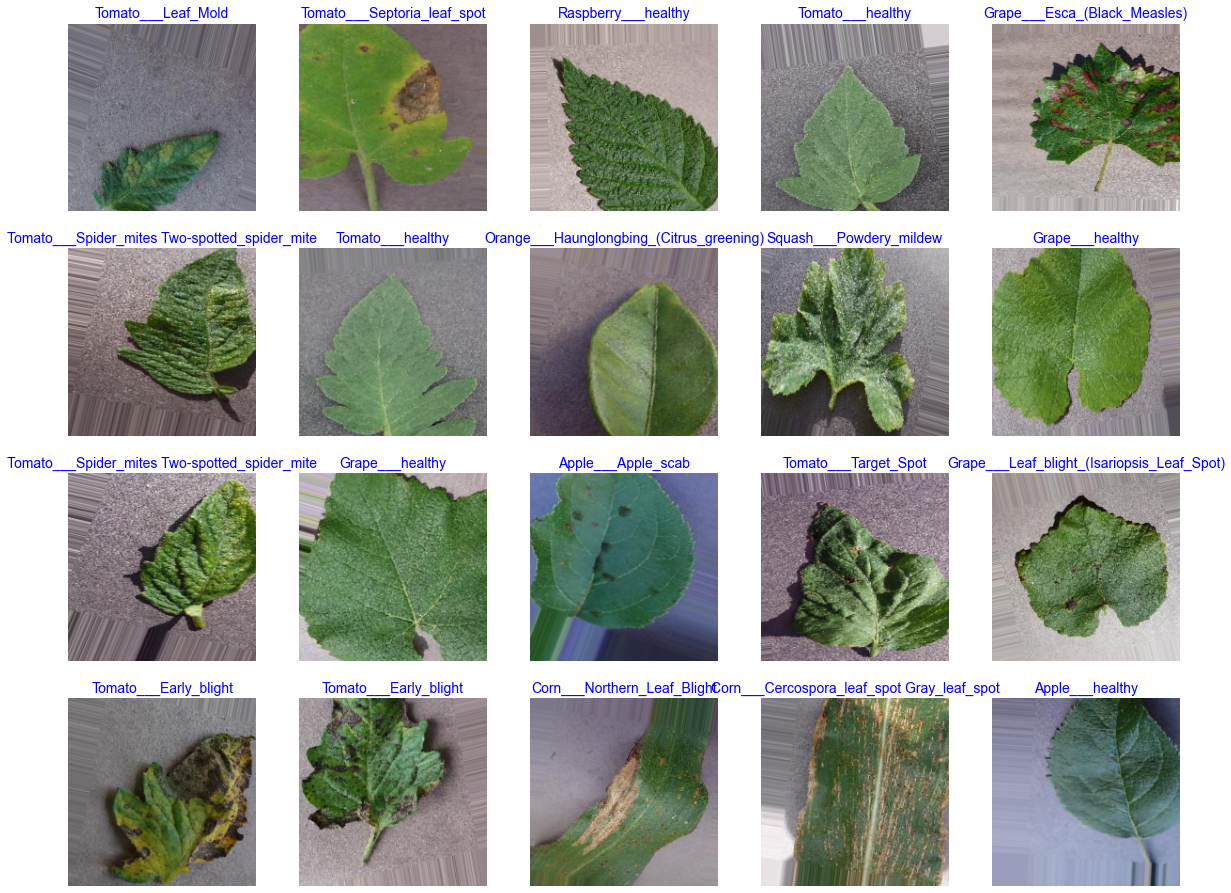

In [9]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    images, labels = next(gen)  # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:  # show maximum of 25 images
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen)

In [19]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, epochs, ask_epoch):  # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask = True  # if True query the user on a specified epoch
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()  # set best weights to model's initial weights
        self.best_epoch = 1

    def on_train_begin(self, logs=None):  # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:  # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask = False  # do not query the user
        if self.epochs == 1:
            self.ask = False  # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch, ' then you will be asked to')
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time = time.time()  # set the time at which training started

    def on_train_end(self, logs=None):  # runs at the end of training
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights)  # set the weights of the model to the best weights
        tr_duration = time.time() - self.start_time  # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg, flush=True)  # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss < self.lowest_vloss:
            self.lowest_vloss = v_loss
            self.best_weights = self.model.get_weights()  # set best weights to model's initial weights
            self.best_epoch = epoch + 1
            print(
                f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print(
                f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')

        if self.ask:  # are the conditions right to query the user?
            if epoch + 1 == self.ask_epoch:  # is this epoch the one for quering the user?
                print(
                    '\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans = input()

                if ans == 'H' or ans == 'h' or ans == '0':  # quit training for these conditions
                    print('you entered ', ans, ' Training halted on epoch ', epoch + 1, ' due to user input\n',
                          flush=True)
                    self.model.stop_training = True  # halt training
                else:  # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ',
                              self.ask_epoch, flush=True)
                    else:
                        print('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))  # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans = input(' ')
                        if ans == '':
                            print(f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr = float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr,
                                                       new_lr)  # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [9]:
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]

In [10]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
380/380 [==============================] - ETA: 0s - loss: 7.0984 - accuracy: 0.7150
 validation loss of  4.6568 is below lowest loss, saving weights from epoch 1   as best weights
380/380 [==============================] - 1997s 5s/step - loss: 7.0984 - accuracy: 0.7150 - val_loss: 4.6568 - val_accuracy: 0.9330
Epoch 2/40
380/380 [==============================] - ETA: 0s - loss: 3.5141 - accuracy: 0.9243
 validation loss of  2.3790 is below lowest loss, saving weights from epoch 2   as best weights
380/380 [==============================] - 1777s 5s/step - loss: 3.5141 - accuracy: 0.9243 - val_loss: 2.3790 - val_accuracy: 0.9551
Epoch 3/40
380/380 [==============================] - ETA: 0s - loss: 1.8221 - accuracy: 0.9576
 validation loss of  1.2451 is below lowest loss, saving weights from epoch 3   as best weigh

In [11]:
test_loss, test_acc = model.evaluate(test_gen, steps=test_steps)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

97/97 [==============================] - 98s 995ms/step - loss: 0.6145 - accuracy: 0.9709
Test Loss: 0.6144888401031494
Test Accuracy: 0.9709131121635437


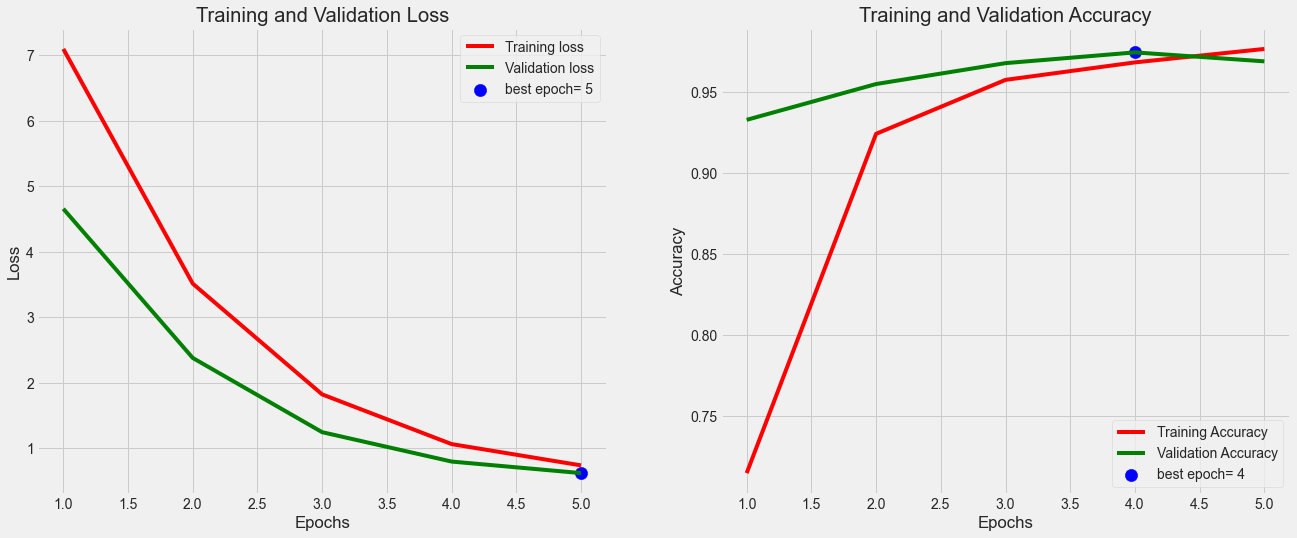

In [12]:
def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()


tr_plot(history, 0)

In [17]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predictor(test_gen, test_steps):
    y_pred = []
    y_true = test_gen.labels[:len(test_gen.filenames)]  # Slice y_true to match the length of y_pred
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)
    
    image_limit = 10  # Limit the number of predicted images shown
    image_count = 0  # Counter for the number of predicted images displayed
    
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = y_true[i]  # labels are integer values
        if pred_index != true_index:  # a misclassification has occurred
            errors += 1
        y_pred.append(pred_index)

        # Show the predicted image, true label, and predicted label
        if image_count < image_limit:
            try:
                image_path = test_gen.filepaths[i]
                image = plt.imread(image_path)
                plt.imshow(image)
                plt.axis('off')  # Hide axis
                plt.title(f"True Label: {classes[true_index]}\nPredicted Label: {classes[pred_index]}")
                plt.show()
                
                image_count += 1  # Increment the counter for displayed images
            except Exception as e:
                print(f"Error displaying image: {e}")
    
    acc = (1 - errors / tests) * 100
    print(f'There were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    print("Shape of y_true:", y_true.shape)
    print("Shape of y_pred:", y_pred.shape)
    
    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)  # create classification report
    print("Classification Report:\n----------------------\n", clr)
    
    return errors, tests

# Call the predictor function
errors, tests = predictor(test_gen, test_steps)

97/97 [==============================] - 100s 1s/step
True Label: Strawberry___Leaf_scorch
Predicted Label: Strawberry___Leaf_scorch

True Label: Soybean___healthy
Predicted Label: Soybean___healthy

True Label: Pepper,_bell___healthy
Predicted Label: Pepper,_bell___healthy

True Label: Tomato___healthy
Predicted Label: Tomato___healthy

True Label: Orange___Haunglongbing_(Citrus_greening)
Predicted Label: Orange___Haunglongbing_(Citrus_greening)

There were 79 errors in 2716 tests for an accuracy of  97.09
Shape of y_true: (2716,)
Shape of y_pred: (2716,)
Classification Report:
----------------------
                                                precision    recall  f1-score   support

                           Apple___Apple_scab     1.0000    1.0000    1.0000        31
                            Apple___Black_rot     0.9688    1.0000    0.9841        31
                     Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        13
                              Apple___hea

In [ ]:
#subject = 'plant disease'
#acc = str((1 - errors/tests) * 100)
#index = acc.rfind('.')
#acc = acc[:index + 3]
#save_id = subject + '_' + str(acc)
#model_save_loc = os.path.join(working_dir, save_id)
#tf.saved_model.save(model, model_save_loc)
#print('Model was saved as', model_save_loc)

EfficientNetB0 Model

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the base model's layers
base_model.trainable = False

# Add custom classification head on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(class_count, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                              

                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_b

 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
          

                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
          

                                                                                                  
 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation) 

In [11]:
steps_per_epoch = len(train_gen)
validation_steps = len(valid_gen)
epochs = 10

# Train the model
history = model.fit(train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=valid_gen, validation_steps=validation_steps)

Epoch 1/10
380/380 [==============================] - 497s 1s/step - loss: 0.9905 - accuracy: 0.7295 - val_loss: 0.4283 - val_accuracy: 0.8692
Epoch 2/10
380/380 [==============================] - 524s 1s/step - loss: 0.3722 - accuracy: 0.8813 - val_loss: 0.2968 - val_accuracy: 0.9035
Epoch 3/10
380/380 [==============================] - 500s 1s/step - loss: 0.2805 - accuracy: 0.9130 - val_loss: 0.2693 - val_accuracy: 0.9109
Epoch 4/10
380/380 [==============================] - 483s 1s/step - loss: 0.2205 - accuracy: 0.9267 - val_loss: 0.2902 - val_accuracy: 0.9009
Epoch 5/10
380/380 [==============================] - 524s 1s/step - loss: 0.2045 - accuracy: 0.9324 - val_loss: 0.2261 - val_accuracy: 0.9289
Epoch 6/10
380/380 [==============================] - 519s 1s/step - loss: 0.1961 - accuracy: 0.9328 - val_loss: 0.2024 - val_accuracy: 0.9285
Epoch 7/10
380/380 [==============================] - 512s 1s/step - loss: 0.1654 - accuracy: 0.9450 - val_loss: 0.1857 - val_accuracy: 0.9385

In [12]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

97/97 [==============================] - 128s 1s/step - loss: 0.2069 - accuracy: 0.9326
Test Loss: 0.2069348394870758
Test Accuracy: 0.9326214790344238


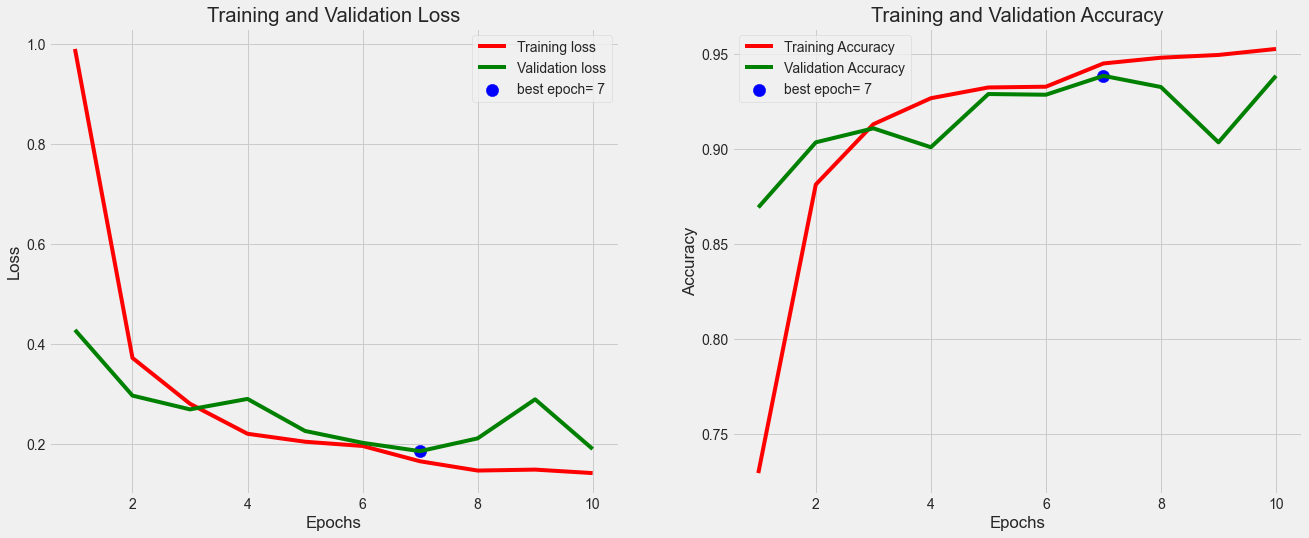

In [13]:
def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()


tr_plot(history, 0)

97/97 [==============================] - 125s 1s/step


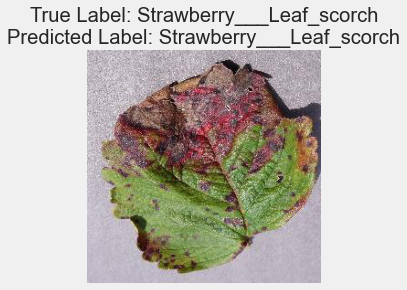

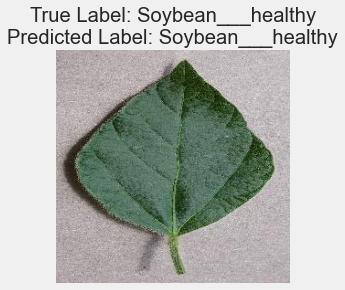

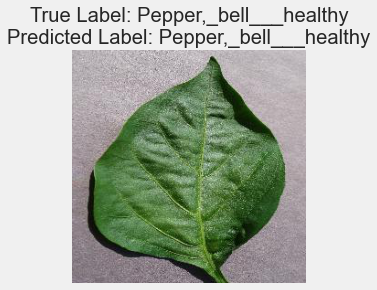

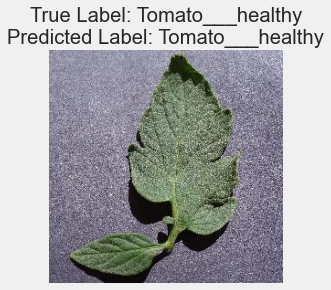

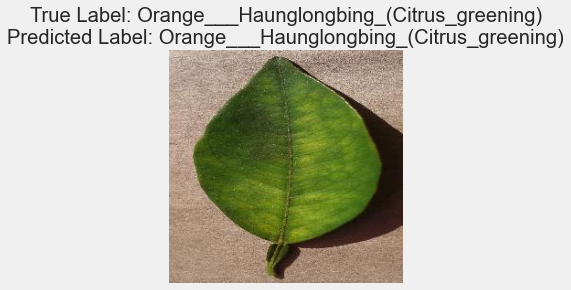

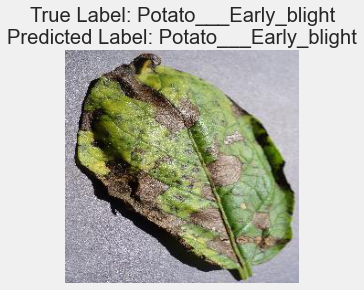

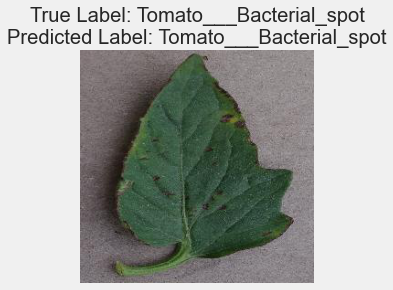

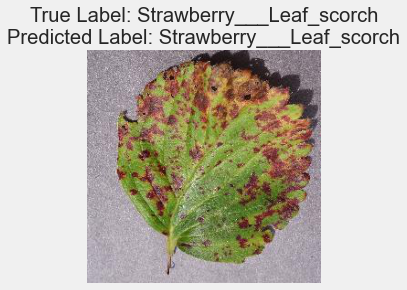

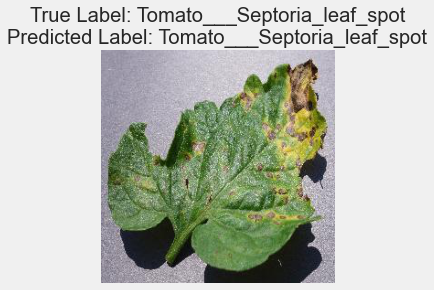

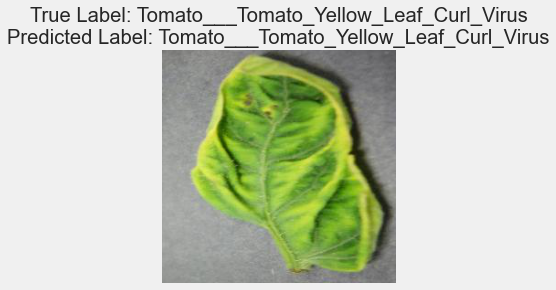

There were 183 errors in 2716 tests for an accuracy of  93.26
Shape of y_true: (2716,)
Shape of y_pred: (2716,)
Classification Report:
----------------------
                                                precision    recall  f1-score   support

                           Apple___Apple_scab     1.0000    0.9355    0.9667        31
                            Apple___Black_rot     0.9677    0.9677    0.9677        31
                     Apple___Cedar_apple_rust     0.9286    1.0000    0.9630        13
                              Apple___healthy     1.0000    0.9639    0.9816        83
                          Blueberry___healthy     0.9867    0.9867    0.9867        75
                      Cherry___Powdery_mildew     0.9636    1.0000    0.9815        53
                             Cherry___healthy     0.7500    1.0000    0.8571        42
   Corn___Cercospora_leaf_spot Gray_leaf_spot     0.7188    0.9200    0.8070        25
                           Corn___Common_rust     1.0000 

In [14]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predictor(test_gen, test_steps):
    y_pred = []
    y_true = test_gen.labels[:len(test_gen.filenames)]  # Slice y_true to match the length of y_pred
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)
    
    image_limit = 10  # Limit the number of predicted images shown
    image_count = 0  # Counter for the number of predicted images displayed
    
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = y_true[i]  # labels are integer values
        if pred_index != true_index:  # a misclassification has occurred
            errors += 1
        y_pred.append(pred_index)

        # Show the predicted image, true label, and predicted label
        if image_count < image_limit:
            try:
                image_path = test_gen.filepaths[i]
                image = plt.imread(image_path)
                plt.imshow(image)
                plt.axis('off')  # Hide axis
                plt.title(f"True Label: {classes[true_index]}\nPredicted Label: {classes[pred_index]}")
                plt.show()
                
                image_count += 1  # Increment the counter for displayed images
            except Exception as e:
                print(f"Error displaying image: {e}")
    
    acc = (1 - errors / tests) * 100
    print(f'There were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    print("Shape of y_true:", y_true.shape)
    print("Shape of y_pred:", y_pred.shape)
    
    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)  # create classification report
    print("Classification Report:\n----------------------\n", clr)
    
    return errors, tests

# Call the predictor function
errors, tests = predictor(test_gen, test_steps)

EfficientNetB1 model

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Load the pre-trained EfficientNetB1 model
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(class_count, activation='softmax')(x)  

# Add custom classification head on top of the base model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

27018416/27018416 [==============================] - 8s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                           

 block1b_add (Add)              (None, 112, 112, 16  0           ['block1b_drop[0][0]',           
                                )                                 'block1a_project_bn[0][0]']     
                                                                                                  
 block2a_expand_conv (Conv2D)   (None, 112, 112, 96  1536        ['block1b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 112, 112, 96  384        ['block2a_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block2a_expand_activation (Act  (None, 112, 112, 96  0          ['block2a_expand_bn[0][0]']      
 ivation) 

 ization)                                                                                         
                                                                                                  
 block2c_expand_activation (Act  (None, 56, 56, 144)  0          ['block2c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 56, 56, 144)  1296       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 56, 56, 144)  576        ['block2c_dwconv[0][0]']         
 )                                                                                                
          

                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 28, 28, 240)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_s

 )                                                                                                
                                                                                                  
 block4a_activation (Activation  (None, 14, 14, 240)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 240)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_s

 block4c_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4c_se_reshape[0][0]']     
                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 14, 14, 80)   38400       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4c_project_conv[0][0]']   
 lization)

                                                                  'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, 14, 14, 112)  53760       ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5b_expand_conv[0][0]']    
 ization) 

                                                                  'block5b_add[0][0]']            
                                                                                                  
 block5d_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5c_add[0][0]']            
                                                                                                  
 block5d_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5d_expand_activation (Act  (None, 14, 14, 672)  0          ['block5d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5d_d

 block6b_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  28800       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6b_activation (Activation  (None, 7, 7, 1152)  0           ['block6b_bn[0][0]']             
 )        

                                                                                                  
 block6d_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 7, 7, 1152)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_s

 )                                                                                                
                                                                                                  
 block7a_se_squeeze (GlobalAver  (None, 1152)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
          

In [16]:
steps_per_epoch = len(train_gen)
validation_steps = len(valid_gen)
epochs = 10

# Train the model
history = model.fit(train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=valid_gen, validation_steps=validation_steps)

Epoch 1/10
380/380 [==============================] - 816s 2s/step - loss: 1.0302 - accuracy: 0.7120 - val_loss: 0.5569 - val_accuracy: 0.8239
Epoch 2/10
380/380 [==============================] - 776s 2s/step - loss: 0.4061 - accuracy: 0.8707 - val_loss: 0.4137 - val_accuracy: 0.8703
Epoch 3/10
380/380 [==============================] - 774s 2s/step - loss: 0.3152 - accuracy: 0.8961 - val_loss: 0.3033 - val_accuracy: 0.9024
Epoch 4/10
380/380 [==============================] - 721s 2s/step - loss: 0.2595 - accuracy: 0.9129 - val_loss: 0.2657 - val_accuracy: 0.9193
Epoch 5/10
380/380 [==============================] - 712s 2s/step - loss: 0.2380 - accuracy: 0.9242 - val_loss: 0.2347 - val_accuracy: 0.9223
Epoch 6/10
380/380 [==============================] - 403s 1s/step - loss: 0.2205 - accuracy: 0.9282 - val_loss: 0.2831 - val_accuracy: 0.9072
Epoch 7/10
380/380 [==============================] - 314s 825ms/step - loss: 0.2069 - accuracy: 0.9296 - val_loss: 0.2615 - val_accuracy: 0.9

In [17]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

97/97 [==============================] - 77s 795ms/step - loss: 0.1927 - accuracy: 0.9297
Test Loss: 0.1927288919687271
Test Accuracy: 0.9296759963035583


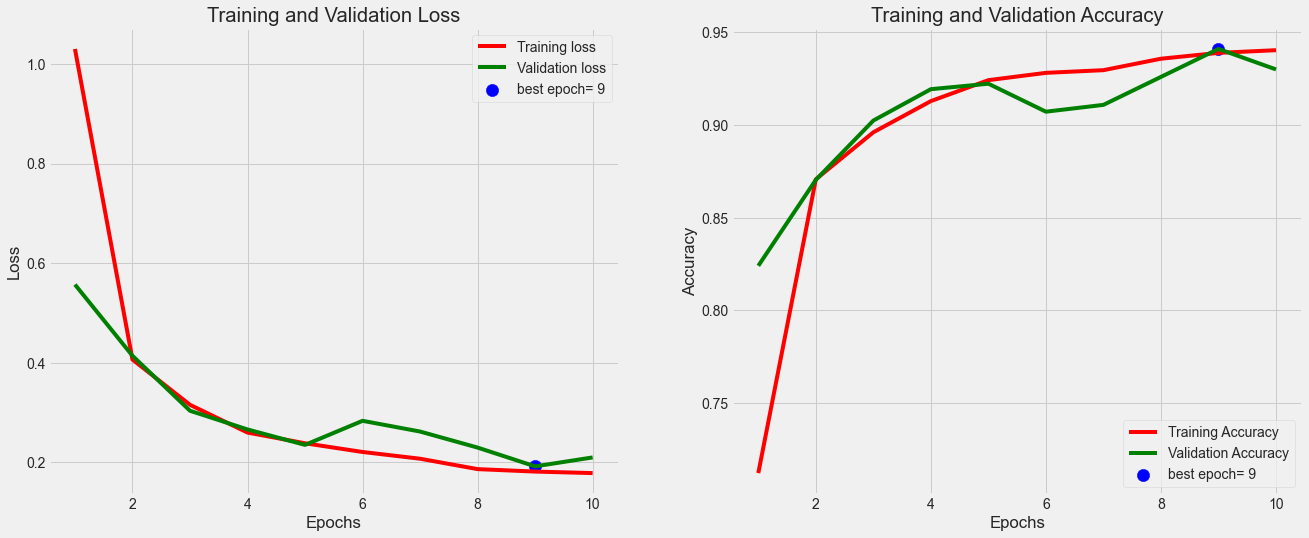

In [18]:
def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()


tr_plot(history, 0)

97/97 [==============================] - 79s 783ms/step


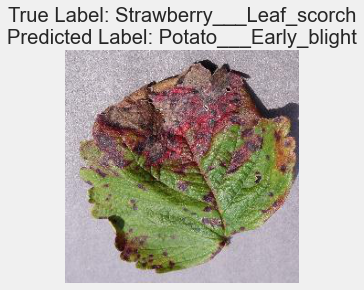

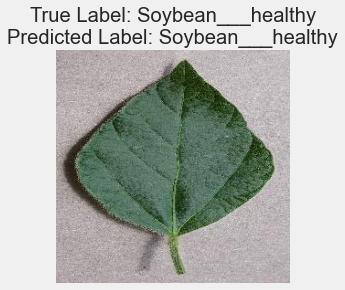

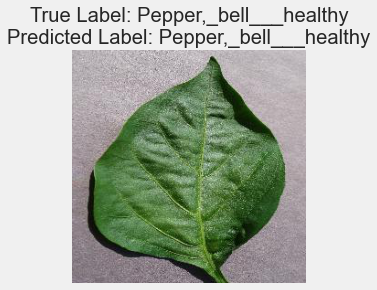

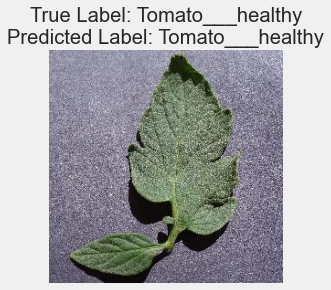

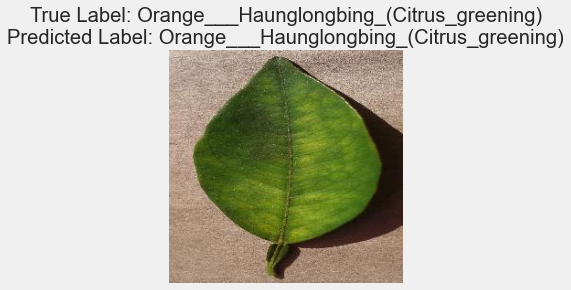

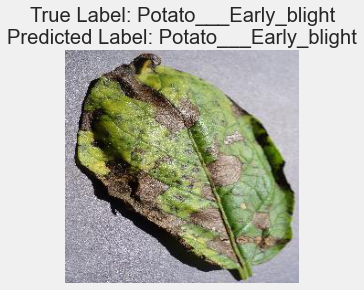

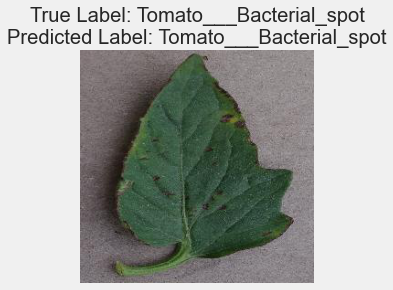

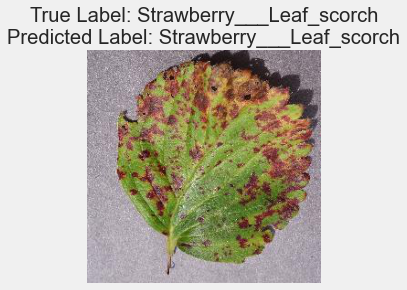

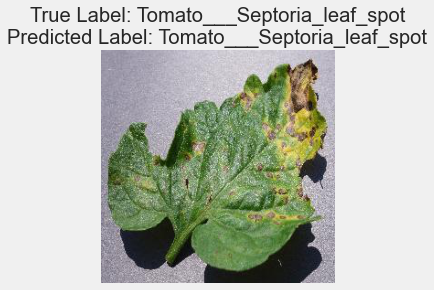

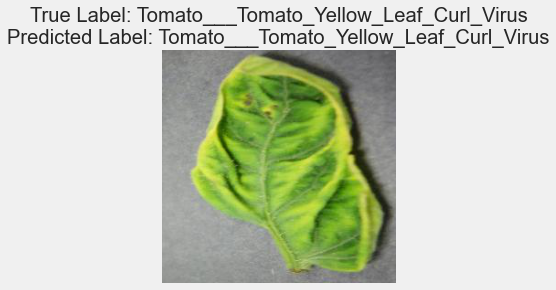

There were 191 errors in 2716 tests for an accuracy of  92.97
Shape of y_true: (2716,)
Shape of y_pred: (2716,)
Classification Report:
----------------------
                                                precision    recall  f1-score   support

                           Apple___Apple_scab     0.9032    0.9032    0.9032        31
                            Apple___Black_rot     0.6078    1.0000    0.7561        31
                     Apple___Cedar_apple_rust     0.8125    1.0000    0.8966        13
                              Apple___healthy     0.9867    0.8916    0.9367        83
                          Blueberry___healthy     1.0000    0.9867    0.9933        75
                      Cherry___Powdery_mildew     1.0000    0.9434    0.9709        53
                             Cherry___healthy     0.8936    1.0000    0.9438        42
   Corn___Cercospora_leaf_spot Gray_leaf_spot     0.8065    1.0000    0.8929        25
                           Corn___Common_rust     0.9524 

In [19]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predictor(test_gen, test_steps):
    y_pred = []
    y_true = test_gen.labels[:len(test_gen.filenames)]  # Slice y_true to match the length of y_pred
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)
    
    image_limit = 10  # Limit the number of predicted images shown
    image_count = 0  # Counter for the number of predicted images displayed
    
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = y_true[i]  # labels are integer values
        if pred_index != true_index:  # a misclassification has occurred
            errors += 1
        y_pred.append(pred_index)

        # Show the predicted image, true label, and predicted label
        if image_count < image_limit:
            try:
                image_path = test_gen.filepaths[i]
                image = plt.imread(image_path)
                plt.imshow(image)
                plt.axis('off')  # Hide axis
                plt.title(f"True Label: {classes[true_index]}\nPredicted Label: {classes[pred_index]}")
                plt.show()
                
                image_count += 1  # Increment the counter for displayed images
            except Exception as e:
                print(f"Error displaying image: {e}")
    
    acc = (1 - errors / tests) * 100
    print(f'There were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    print("Shape of y_true:", y_true.shape)
    print("Shape of y_pred:", y_pred.shape)
    
    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)  # create classification report
    print("Classification Report:\n----------------------\n", clr)
    
    return errors, tests

# Call the predictor function
errors, tests = predictor(test_gen, test_steps)

EfficientNetB2 model

In [22]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained EfficientNet-B2 model without the top (fully connected) layers
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add your own classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(class_count, activation='softmax')(x)  

# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


train_labels = len(train_gen)
validation_steps = len(valid_gen)
epochs = 10
# Train the model on your dataset
history = model.fit(train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=valid_gen, validation_steps=validation_steps)

Epoch 1/10
380/380 [==============================] - 392s 981ms/step - loss: 1.0193 - accuracy: 0.7118 - val_loss: 0.3911 - val_accuracy: 0.8814
Epoch 2/10
380/380 [==============================] - 369s 967ms/step - loss: 0.4228 - accuracy: 0.8646 - val_loss: 0.3009 - val_accuracy: 0.9061
Epoch 3/10
380/380 [==============================] - 412s 1s/step - loss: 0.3628 - accuracy: 0.8750 - val_loss: 0.3674 - val_accuracy: 0.8729
Epoch 4/10
380/380 [==============================] - 408s 1s/step - loss: 0.2864 - accuracy: 0.9034 - val_loss: 0.2515 - val_accuracy: 0.9157
Epoch 5/10
380/380 [==============================] - 369s 965ms/step - loss: 0.2697 - accuracy: 0.9103 - val_loss: 0.2842 - val_accuracy: 0.8994
Epoch 6/10
380/380 [==============================] - 345s 903ms/step - loss: 0.2473 - accuracy: 0.9161 - val_loss: 0.2506 - val_accuracy: 0.9186
Epoch 7/10
380/380 [==============================] - 343s 897ms/step - loss: 0.2284 - accuracy: 0.9221 - val_loss: 0.2141 - val_a

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))

97/97 [==============================] - 84s 850ms/step - loss: 0.2233 - accuracy: 0.9256


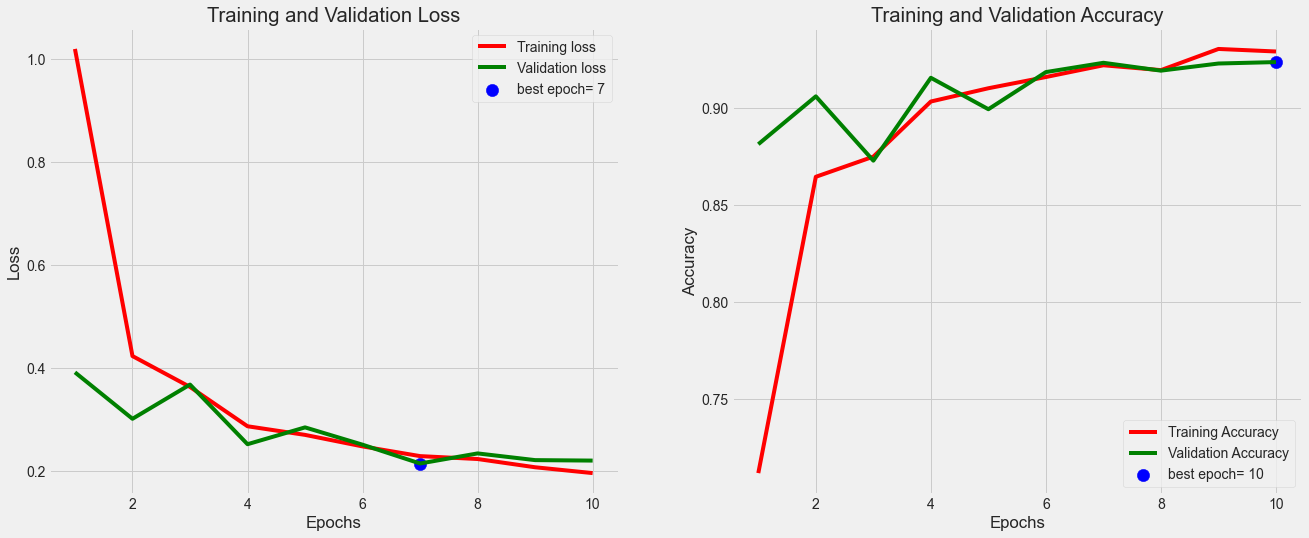

In [25]:
def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()


tr_plot(history, 0)

97/97 [==============================] - 92s 872ms/step


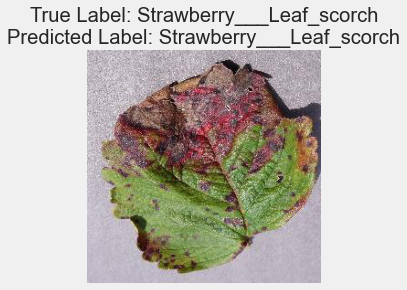

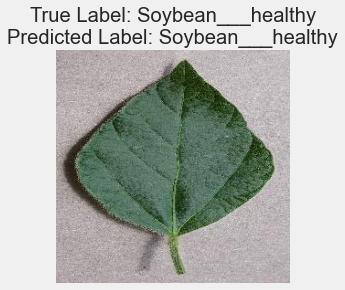

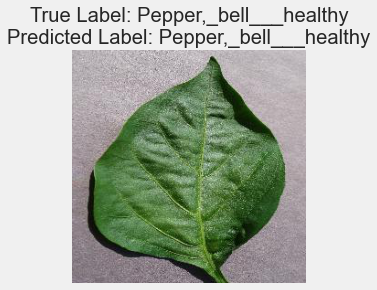

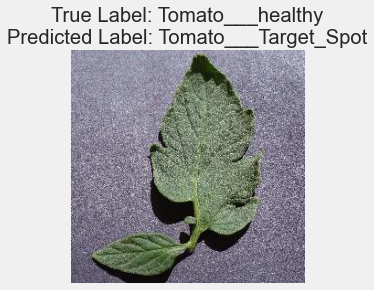

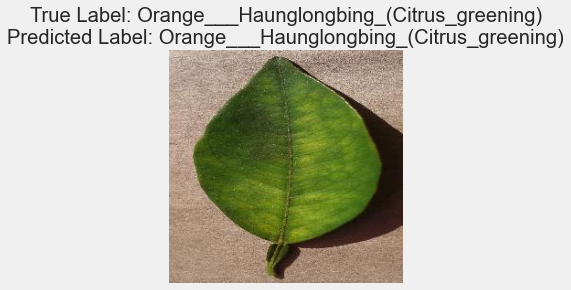

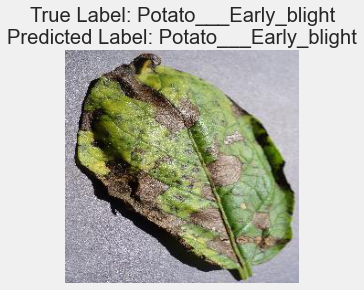

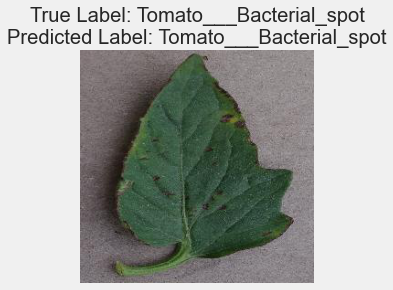

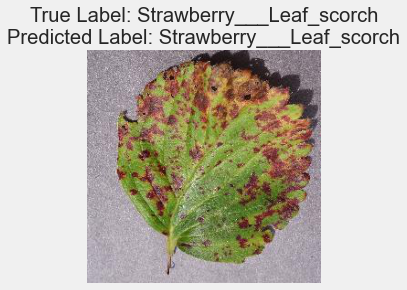

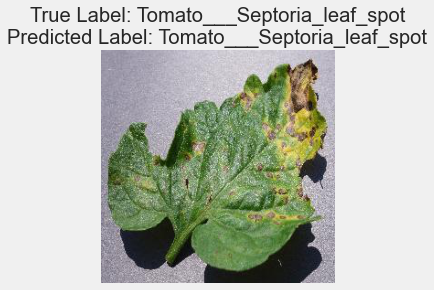

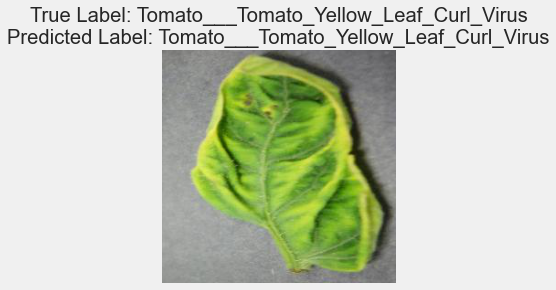

There were 202 errors in 2716 tests for an accuracy of  92.56
Shape of y_true: (2716,)
Shape of y_pred: (2716,)
Classification Report:
----------------------
                                                precision    recall  f1-score   support

                           Apple___Apple_scab     0.8333    0.9677    0.8955        31
                            Apple___Black_rot     0.9677    0.9677    0.9677        31
                     Apple___Cedar_apple_rust     0.9286    1.0000    0.9630        13
                              Apple___healthy     0.9412    0.9639    0.9524        83
                          Blueberry___healthy     0.9737    0.9867    0.9801        75
                      Cherry___Powdery_mildew     0.9615    0.9434    0.9524        53
                             Cherry___healthy     1.0000    1.0000    1.0000        42
   Corn___Cercospora_leaf_spot Gray_leaf_spot     0.6667    0.9600    0.7869        25
                           Corn___Common_rust     0.9836 

In [26]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predictor(test_gen, test_steps):
    y_pred = []
    y_true = test_gen.labels[:len(test_gen.filenames)]  # Slice y_true to match the length of y_pred
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)
    
    image_limit = 10  # Limit the number of predicted images shown
    image_count = 0  # Counter for the number of predicted images displayed
    
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = y_true[i]  # labels are integer values
        if pred_index != true_index:  # a misclassification has occurred
            errors += 1
        y_pred.append(pred_index)

        # Show the predicted image, true label, and predicted label
        if image_count < image_limit:
            try:
                image_path = test_gen.filepaths[i]
                image = plt.imread(image_path)
                plt.imshow(image)
                plt.axis('off')  # Hide axis
                plt.title(f"True Label: {classes[true_index]}\nPredicted Label: {classes[pred_index]}")
                plt.show()
                
                image_count += 1  # Increment the counter for displayed images
            except Exception as e:
                print(f"Error displaying image: {e}")
    
    acc = (1 - errors / tests) * 100
    print(f'There were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    print("Shape of y_true:", y_true.shape)
    print("Shape of y_pred:", y_pred.shape)
    
    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)  # create classification report
    print("Classification Report:\n----------------------\n", clr)
    
    return errors, tests

# Call the predictor function
errors, tests = predictor(test_gen, test_steps)